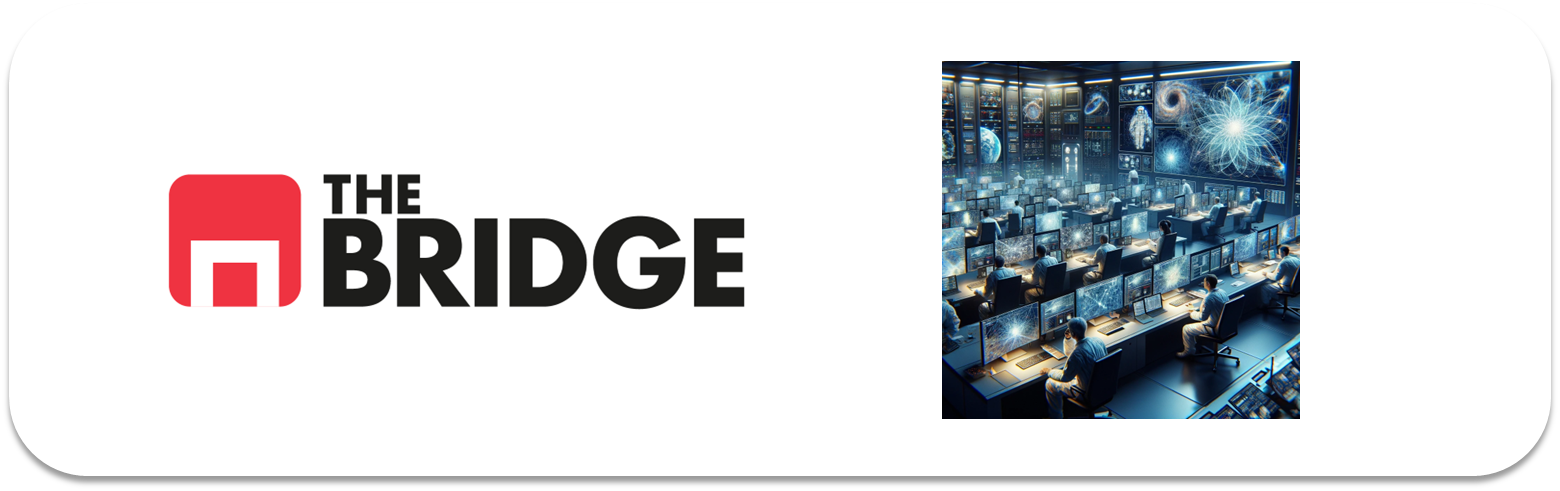

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import keras
import cv2
import zipfile

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Prepracion de los datos

In [82]:
!mkdir data_descomprimido

In [83]:
ruta_zip = "./data/"
extract_to = "./data_descomprimido/"

for archivo in os.listdir(ruta_zip):
      with zipfile.ZipFile(os.path.join(ruta_zip, archivo), 'r') as zip_ref: #descomprimos las carpetas de la ruta indicada con el formato de lectura 'r'
        zip_ref.extractall(extract_to) #extraemos a la nueva carpeta

In [4]:
#usamos la funcion empleada en el workout para el procesado de imagenes y agrupación de datos en sets de train y tesy
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [5]:
#establecemos las rutas a los directorios que usaremos para la funcion

ROOT_PATH = './data_descomprimido/'
TRAIN_PATH = ROOT_PATH + "train/" #creo una carpeta train con las subcarpetas para que la función pueda leerlo correctamente. De otra forma, devuelve un array vacío
TEST_PATH = ROOT_PATH + "test/" #es el mismo caso que en train

In [15]:
X_train, y_train = read_data(TRAIN_PATH)

github_train_0
github_train_1
github_train_2
github_train_3


In [7]:
print(X_train.shape)
print(y_train.shape)

(4000, 32, 32, 3)
(4000,)


In [8]:
X_test, y_test = read_data(TEST_PATH)

github_test


In [9]:
print(X_test.shape)
print(y_test.shape)

(1000, 32, 32, 3)
(1000,)


*Comprobamos cómo se visualizan las imagenes*

In [28]:
#recurrimos a la función del workout para visualizar sets de imagenes:
def show_images_batch(foto, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(foto) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(foto):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys") #train está en RGB e ignora el parametro cmap
        plt.axis("off")
        if len(names):
            plt.title(names[index])

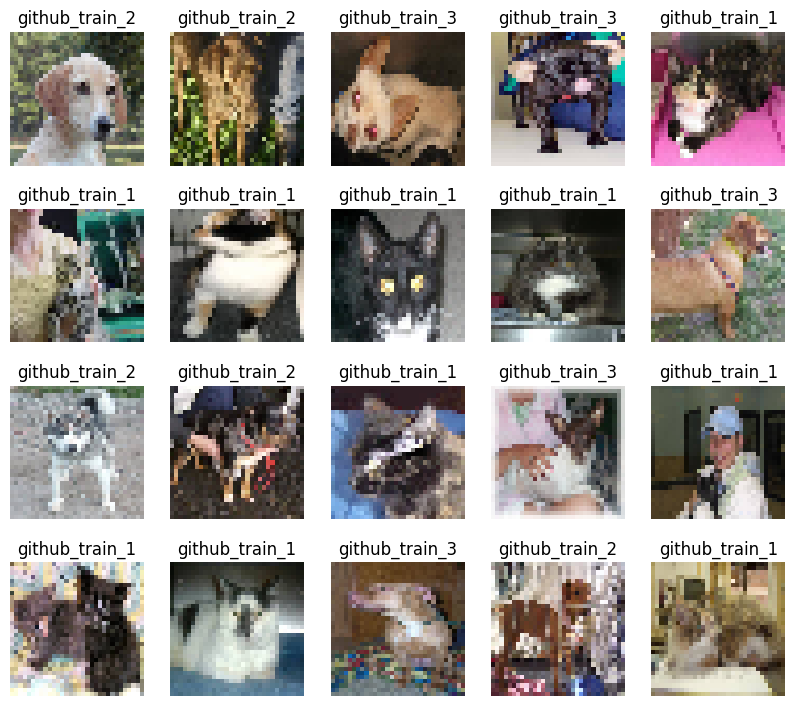

In [18]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

*Toma como índice el nombre de cada carpeta, ajustamos la función para que lea y almacene en y como etiqueta el nombre de cada foto*

In [21]:
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)

                #adaptamos la funcion para que lea el titulo de las fotos como etiqueta en vez de la carpeta:

                if 'cat' in file.lower(): #aseguramos que esten en minusculas
                    y.append('cat')
                elif 'dog' in file.lower():
                    y.append('dog')
                else:
                    y.append('unknow') #por si encuentra alguna mal etiquetada o diferente

    return np.array(X),np.array(y)

In [22]:
X_train_set, y_train_set = read_data(TRAIN_PATH)

github_train_0
github_train_1
github_train_2
github_train_3


In [23]:
X_test_set, y_test_set = read_data(TEST_PATH)

github_test


In [26]:
print(X_train_set.shape, y_train_set.shape)
print(X_test_set.shape, y_test_set.shape)

(4000, 32, 32, 3) (4000,)
(1000, 32, 32, 3) (1000,)


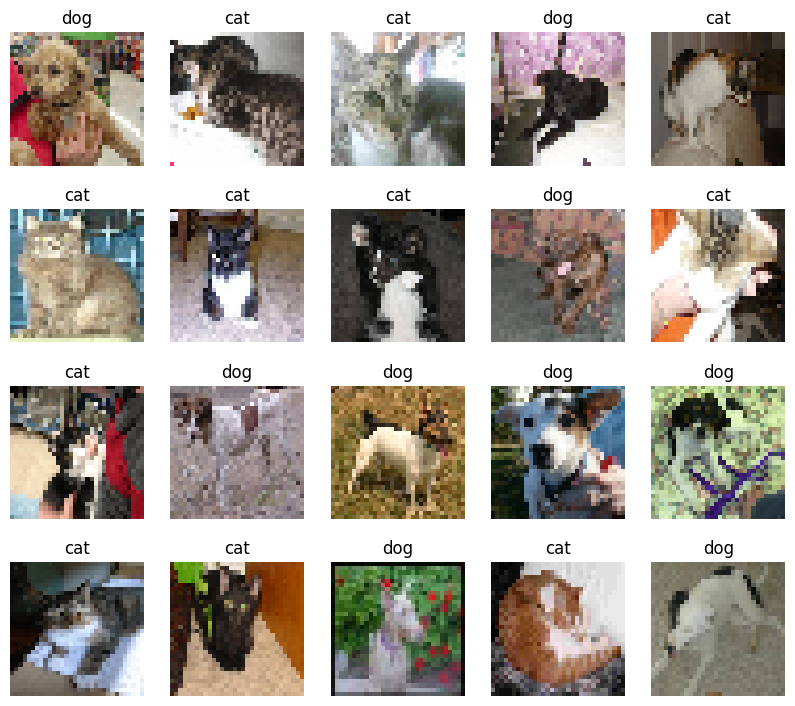

In [27]:
indices = np.random.randint(0,len(X_train_set),20)
show_images_batch(X_train_set[indices], names = y_train_set[indices], n_cols = 5)

##### MiniEDA

In [53]:
target = pd.Series(y_train_set)
target.value_counts(True)

cat    0.5
dog    0.5
Name: proportion, dtype: float64

*Tenemos target totalmente balanceado*  

*Pasamos a tratar los datos en X: normalizar*

In [32]:
X_train_set = X_train_set/255
X_test_set = X_test_set/255

#### Modelado

In [36]:
#primero creamos una lista con todas las capas que añadiremos al modelo:

capas = [keras.layers.Conv2D(filters = 20, kernel_size = (5, 5), input_shape = (32, 32, 3), padding = "same", activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)), #usamos maxpooling para que se quede con el valor más alto del mapeo que realiza el kernel
        keras.layers.Dropout(rate=0.25), #añadimos capa de dropuot para evitar sobreajuste en este punto y tras siguiente pareja de convolucional - pooling
        keras.layers.Conv2D(filters = 10, kernel_size = (3, 3), input_shape = (32, 32, 3), padding = "same", activation = 'relu'), #bajamos los el numero de filtros y kernel.
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(rate=0.25), 
        keras.layers.Flatten(), #capa flatten para aplanar las dimensiones antes de entrar en las capas densas
        keras.layers.Dense(units=100, activation='relu'), #vamos a probar primero con una sola capa densa de 100 neuronas
        keras.layers.Dense(units=2, activation='softmax')]#nuestra capa de salida tendrá dos salidas, una por cada clase. Al tener dos salidas y no una, la activación es softmax


In [37]:
model = keras.Sequential(capas) #creamos el modelo pasandole la lista de capas que hemos montado en la celda anterior

In [41]:
#vamos con los optimizadores, primero comprobamos la cantidad de datos que tendremos en train para determinar si usar Adam o Sgd en caso de tener menos de 1M
print('Total size:', X_train_set.size)
if X_train_set.size > 1000000:
    print('El tamaño de X supera el millón de parámetros: usar Adam como optimizador')
else:
    print('El tamaño de X no es superior al millón de parametros: usar SGD como optimizados')


Total size: 12288000
El tamaño de X supera el millón de parámetros: usar Adam como optimizador


In [40]:
#usaremos Adam como optimizador

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
#escogemos sparse_categorical porque nuestro target tiene una sola dimensión
#usamos accuracy como métrica porque el target esta comletamente balanceado

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 20)     │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 10)     │         1,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        64,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,632 (264.19 KB)

 Trainable params: 67,632 (264.19 KB)

 Non-trainable params: 0 (0.00 B)

##### Entrenamiento

In [43]:
y_train_set_back = pd.Series(y_train_set).copy()
y_test_set_back = pd.Series(y_test_set).copy()

In [57]:
#Antes de entrenar pasamos el target a valores numéricos:
#1 = gato
#0 = perro

etiquetas = {'cat': 1, 
             'dog': 0}

target.replace(etiquetas, inplace=True)

print(target.nunique())
print(target.value_counts(True))#comprobamos

2
1    0.5
0    0.5
Name: proportion, dtype: float64


In [58]:
#hacemos lo mismo con el test:
y_test_num = pd.Series(y_test_set) #lo pasamos a serie para poder usar el metodo replace

y_test_num.replace(etiquetas, inplace=True)

print(y_test_num.nunique())
print(y_test_num.value_counts(True))#comprobamos

2
1    0.5
0    0.5
Name: proportion, dtype: float64


C:\Users\bnove\AppData\Local\Temp\ipykernel_20644\1359199122.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_num.replace(etiquetas, inplace=True)


In [87]:
#definimos el callback
callback = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [88]:
history = model.fit(X_train_set, target, batch_size=32, epochs= 50, validation_split=0.2, callbacks=callback, shuffle=True) #barajamos el set de train para que no aprenda por orden

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7328 - loss: 0.5299 - val_accuracy: 0.6025 - val_loss: 0.6698
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7423 - loss: 0.5084 - val_accuracy: 0.7038 - val_loss: 0.6006
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7459 - loss: 0.5062 - val_accuracy: 0.7275 - val_loss: 0.5637
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7442 - loss: 0.5154 - val_accuracy: 0.3738 - val_loss: 0.9101
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7533 - loss: 0.4880 - val_accuracy: 0.7038 - val_loss: 0.5893
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7683 - loss: 0.4853 - val_accuracy: 0.6237 - val_loss: 0.6636
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7736 - loss: 0.4731 - val_accuracy: 0.7175 - val_loss: 0.5662
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7692 - loss: 0.4692 - val_accuracy: 0.

##### Evolución modelo 1

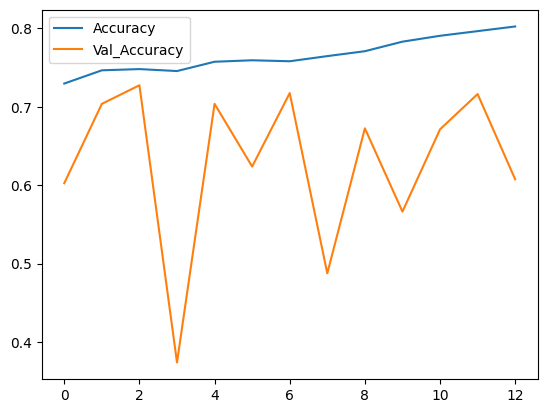

In [89]:
df_history = pd.DataFrame(history.history)
plt.plot(df_history['accuracy'], label= 'Accuracy')
plt.plot(df_history['val_accuracy'], label= 'Val_Accuracy')
plt.legend();


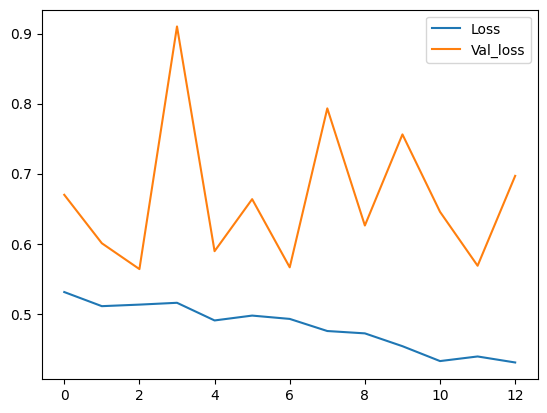

In [90]:
plt.plot(df_history['loss'], label= 'Loss')
plt.plot(df_history['val_loss'], label= 'Val_loss')
plt.legend();

*Parece que tanto la pérdida con el accuracy flutúan mucho en validación mientras que en train es mas o menos lineal. El punto más bajo de pérdida en validación se alcanza pasadas las 6 épocas al igual que el accuracy.*  

*Probamos a cambiar algunos hiperparámetros del modelo, para comprobar si podemos mejorar las métricas*

##### Modelo 2:

In [73]:
capas_2 = [keras.layers.Conv2D(filters = 30, kernel_size = (5, 5), input_shape = (32, 32, 3), padding = "same", activation = 'relu'), #subimos el numero de filtros
        keras.layers.MaxPooling2D(pool_size=(2,2)), 
        keras.layers.Dropout(rate=0.2), #bajamos el dropout a 0.2
        keras.layers.Conv2D(filters = 15, kernel_size = (3, 3), input_shape = (32, 32, 3), padding = "same", activation = 'relu'), 
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(rate=0.2), 
        keras.layers.Flatten(), 
        keras.layers.Dense(units=100, activation='relu'),
        keras.layers.Dense(units= 50, activation='relu'), #añadimos dos capas densas de 100 - 50
        keras.layers.Dense(units=2, activation='softmax')]

model_2 = keras.Sequential(capas_2) 

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #lo dejamos igual que el anterior

callback_2 = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True)

model_2.summary()



c:\Users\bnove\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 30)     │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        96,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,597 (420.30 KB)

 Trainable params: 107,597 (420.30 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
history_2 = model_2.fit(X_train_set, target, batch_size=32, epochs= 100, validation_split=0.2, callbacks=callback_2, shuffle=True)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6127 - loss: 0.6700 - val_accuracy: 0.0000e+00 - val_loss: 0.8799
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6175 - loss: 0.6591 - val_accuracy: 0.5325 - val_loss: 0.6903
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6532 - loss: 0.6300 - val_accuracy: 0.3725 - val_loss: 0.7884
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6679 - loss: 0.6063 - val_accuracy: 0.2725 - val_loss: 0.8877
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6915 - loss: 0.5797 - val_accuracy: 0.1513 - val_loss: 1.1211
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6877 - loss: 0.5846 - val_accuracy: 0.5125 - val_loss: 0.7356
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7176 - loss: 0.5641 - val_accuracy: 0.5788 - val_loss: 0.6742
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7226 - loss: 0.5522 - val_

##### Evolución modelo 2

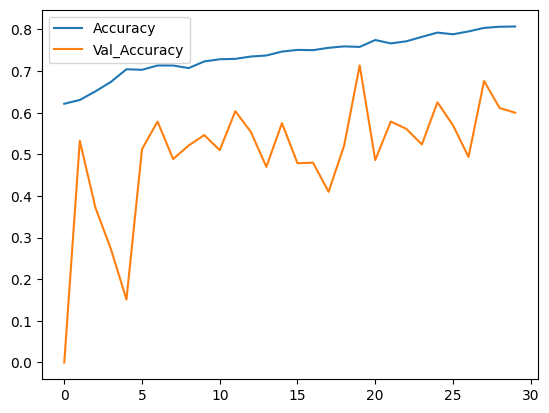

In [79]:
df_history_2 = pd.DataFrame(history_2.history)
plt.plot(df_history_2['accuracy'], label= 'Accuracy')
plt.plot(df_history_2['val_accuracy'], label= 'Val_Accuracy')
plt.legend();


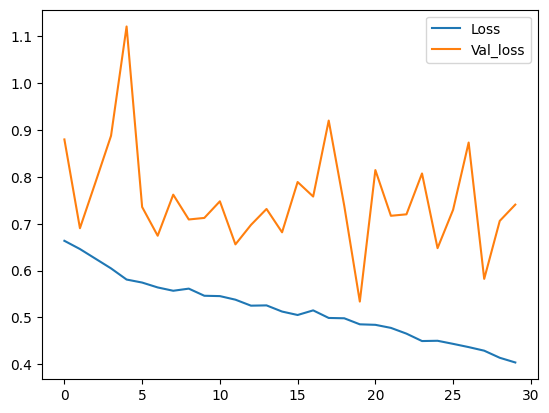

In [80]:
plt.plot(df_history_2['loss'], label= 'Loss')
plt.plot(df_history_2['val_loss'], label= 'Val_loss')
plt.legend();

#### Modelo 3
Probamos a disminuir filtros, kernel y volvemos a una sola capa, paciencia intermedia entre los dos modelos anteriores. Probamos con mismas epocas que en modelo 1 

In [91]:
capas_3 = [keras.layers.Conv2D(filters = 10, kernel_size = (7, 7), input_shape = (32, 32, 3), padding = "same", activation = 'relu'), #subimos el numero de filtros
        keras.layers.MaxPooling2D(pool_size=(2,2)), 
        keras.layers.Dropout(rate=0.2), #bajamos el dropout a 0.2
        keras.layers.Conv2D(filters = 5, kernel_size = (5, 5), input_shape = (32, 32, 3), padding = "same", activation = 'relu'), 
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(rate=0.2), 
        keras.layers.Flatten(), 
        keras.layers.Dense(units=100, activation='relu'),
        keras.layers.Dense(units=2, activation='softmax')]

model_3 = keras.Sequential(capas_3) 

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #lo dejamos igual que el anterior

callback_3 = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

model_3.summary()

c:\Users\bnove\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 10)     │         1,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 5)      │         1,255 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        32,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,037 (136.86 KB)

 Trainable params: 35,037 (136.86 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
history_3 = model_3.fit(X_train_set, target, batch_size=32, epochs= 100, validation_split=0.2, callbacks=callback_3, shuffle=True)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6013 - loss: 0.6787 - val_accuracy: 0.0000e+00 - val_loss: 0.8501
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6169 - loss: 0.6618 - val_accuracy: 0.0000e+00 - val_loss: 0.8895
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6307 - loss: 0.6480 - val_accuracy: 0.0637 - val_loss: 0.8416
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6279 - loss: 0.6425 - val_accuracy: 0.0375 - val_loss: 0.8882
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6269 - loss: 0.6421 - val_accuracy: 0.4400 - val_loss: 0.7581
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6464 - loss: 0.6252 - val_accuracy: 0.0300 - val_loss: 0.9585
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6538 - loss: 0.6199 - val_accuracy: 0.2350 - val_loss: 0.7888
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6688 - loss: 0.6163 - 

##### Evolución modelo 3

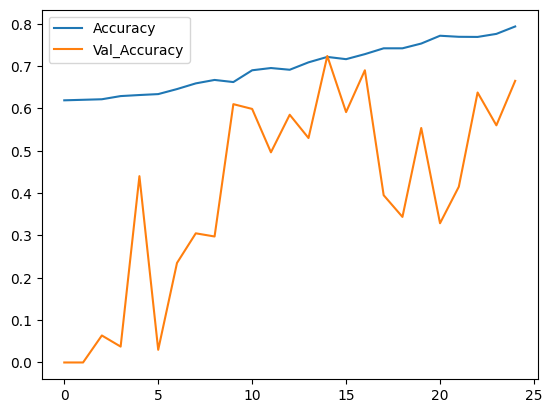

In [93]:
df_history_3 = pd.DataFrame(history_3.history)
plt.plot(df_history_3['accuracy'], label= 'Accuracy')
plt.plot(df_history_3['val_accuracy'], label= 'Val_Accuracy')
plt.legend();


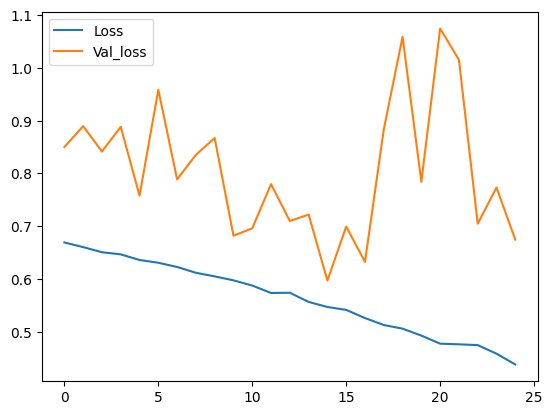

In [94]:
plt.plot(df_history_3['loss'], label= 'Loss')
plt.plot(df_history_3['val_loss'], label= 'Val_loss')
plt.legend();

*Parece que todos los modelos presentan sobre ajuste de los datos en varios puntos si nos fijamos en las funciones de pérdida, lo quiere decir que no son muy buenos. Escogeremos el 2 para el evaluación porque basándonos en la comparación gráfica, parece que tiene mejor descenso de la función de pérdida aunque no es perfecto.*

##### Evaluación

In [95]:
model_2.evaluate(X_test_set, y_test_num)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7112 - loss: 0.5886


[0.5685811638832092, 0.7049999833106995]

In [100]:
y_pred = [np.argmax(prediccion) for prediccion in model.predict(X_test_set)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [124]:
prediccion = classification_report(y_test_num, y_pred)
print(prediccion)

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       500
           1       0.71      0.70      0.70       500

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



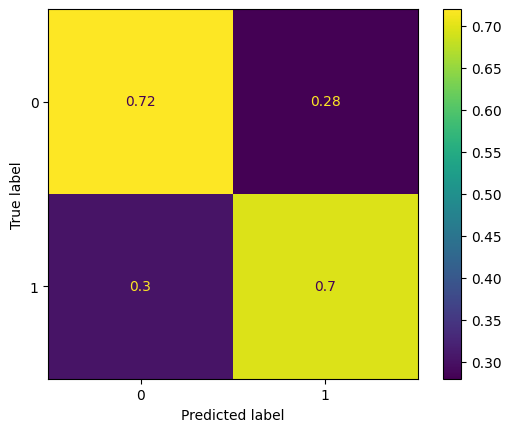

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred, normalize='true')

##### Visualizamos los errores y el nivel de confianza

In [113]:
confianza = [prediccion.max() for prediccion in model_2.predict(X_test_set)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [120]:
df_predicciones = pd.DataFrame({'True_label': y_test_num,
                                'Predición': y_pred,
                                'confianza': confianza})
df_predicciones

,True_label,Predición,confianza
0,1,0,0.603232
1,1,1,0.550805
2,1,1,0.655618
3,1,0,0.542152
4,1,0,0.631400
...,...,...,...
995,0,0,0.601797
996,0,1,0.641083
997,0,0,0.565349
998,0,0,0.533649


In [145]:
errores = df_predicciones['True_label'] != df_predicciones['Predición']
fallos = df_predicciones[errores].sort_values(by='confianza',ascending=False)
fallos

,True_label,Predición,confianza
337,1,0,0.999118
680,0,1,0.993682
851,0,1,0.949400
13,1,0,0.948510
229,1,0,0.937599
...,...,...,...
314,1,0,0.507212
539,0,1,0.506011
867,0,1,0.505383
225,1,0,0.502068


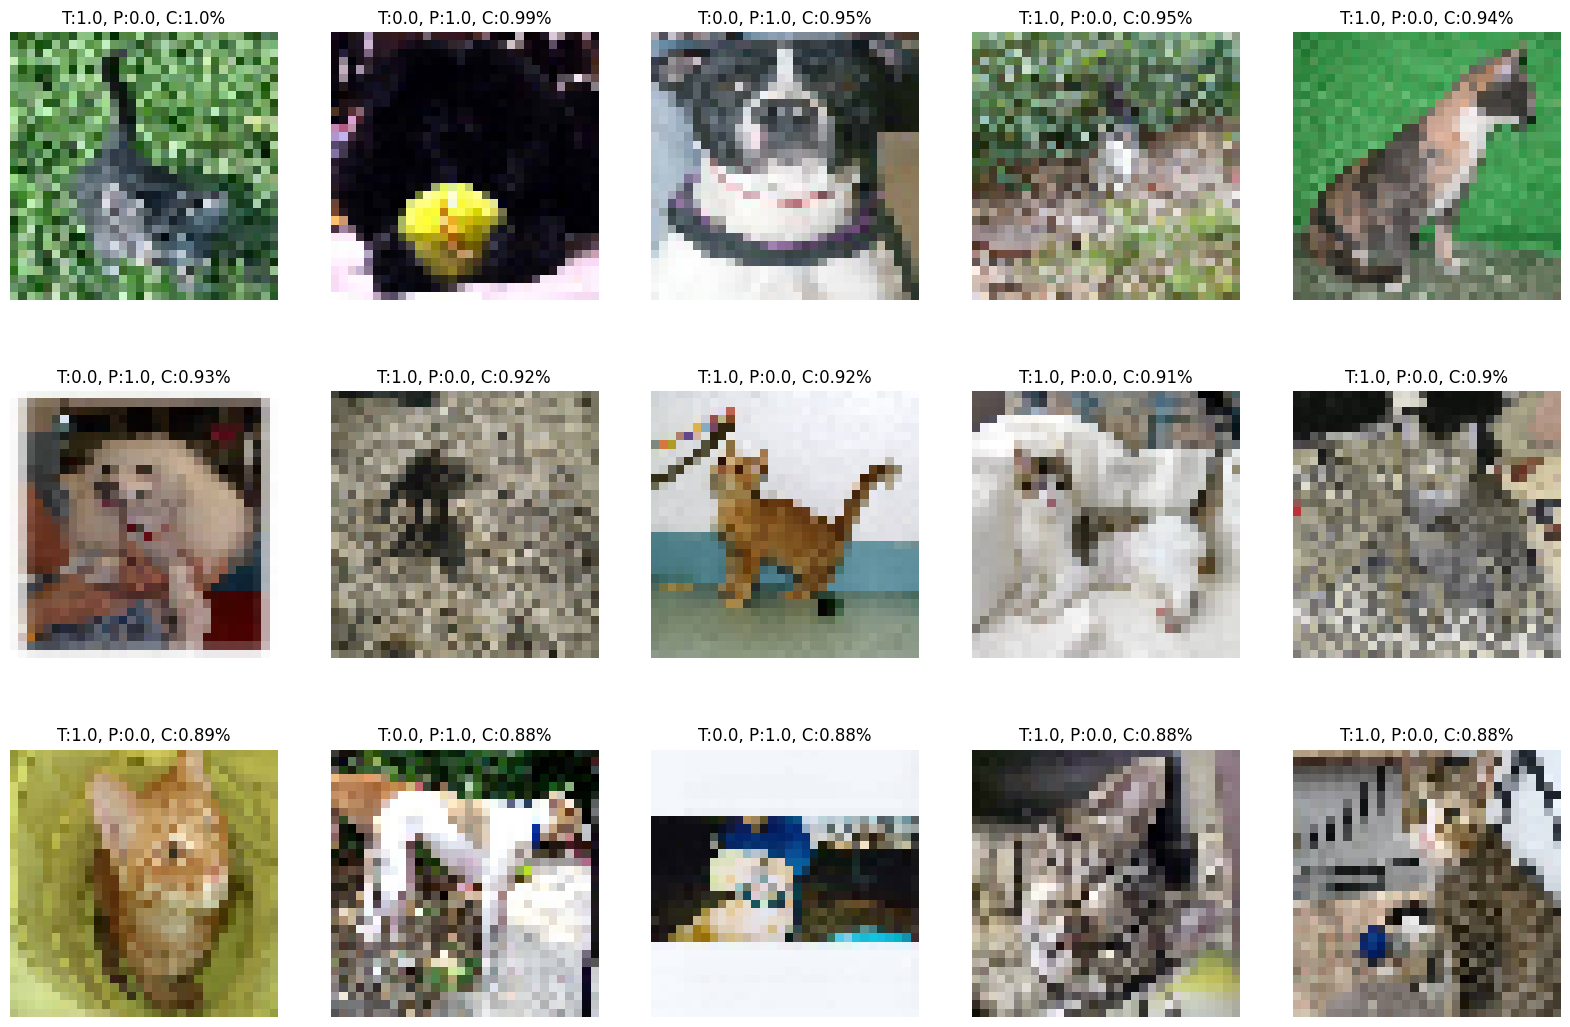

In [146]:
show_images_batch(X_test[fallos.iloc[:15].index], names=[f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in fallos.iloc[:15].values], size_scale= 4)